In [1]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [2]:
import pandas as pd
import os
PATH = os.path.join("", "")
FILENAME="ens_data.csv"
def load_temp_data(temp_path=PATH,file_name=FILENAME):
    csv_path = os.path.join(temp_path, file_name)
    return pd.read_csv(csv_path)


In [3]:
df = load_temp_data()
df.head()

,date,avg temp,avg wind speed,avg humidity,one (hr),uniform rate (%),insolation (MJ/m2),F_day_power
0,1/1/2021,-2.3,2.5,60.4,4.0,40.8,8.78,3130.0
1,1/2/2021,-2.2,3.0,51.0,8.4,85.7,11.83,4340.0
2,1/3/2021,-1.6,3.7,35.6,5.6,57.1,10.27,3530.0
3,1/4/2021,-1.5,2.5,52.3,8.4,85.7,10.97,4040.0
4,1/5/2021,-1.4,3.4,46.8,3.5,35.7,7.28,2600.0


In [4]:
import numpy as np
import warnings
import datetime as dt
from sklearn.impute import SimpleImputer

def pre_data(df):  
    df_tidy = df.copy()
    df_tidy.loc[:,'date'] = pd.to_datetime(df.date.astype(str))
    df_tidy = df_tidy.set_index('date')
    imputer = SimpleImputer()

    data_array = imputer.fit_transform(df_tidy)
    warnings.filterwarnings("ignore")
    df_clean = pd.DataFrame(data=data_array,columns=list(df_tidy.columns),index=df['date'])
    
    return df_clean

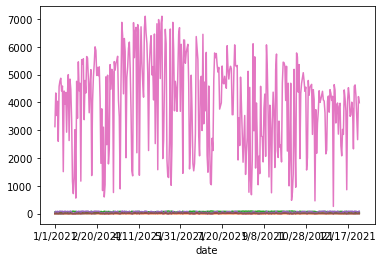

In [5]:
fig, ax = plt.subplots()
df_clean = pre_data(df)
df_clean.plot(legend=False, ax=ax)
plt.show()

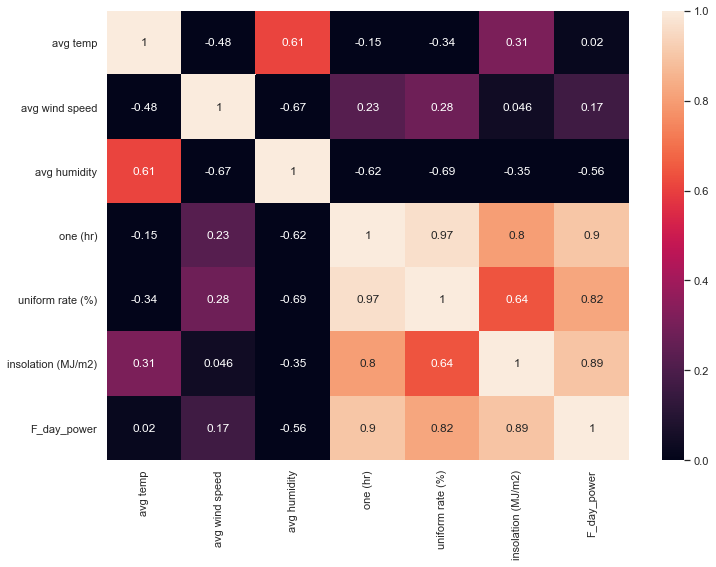

In [6]:
import seaborn as sns

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(df_clean.corr(),vmin=0, vmax=1,annot=True);

In [7]:
x_data = df_clean.drop(['F_day_power'],axis=1)
y_data = df_clean['F_day_power']
x_train = x_data[:300].values
y_train = y_data[:300].values

x_test = x_data[300:].values
y_test = y_data[300:].values


In [8]:
x_train.shape

(300, 6)

In [9]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [10]:
from numpy import array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten,Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D

# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 6
n_seq = 1
n_steps = 1
x_train = x_train.reshape((x_train.shape[0], n_seq, n_steps, n_features))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=32, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
#model.add(TimeDistributed(Dropout(0.05)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(32, activation='relu'))
model.add(Dense(1))
optimizer = keras.optimizers.Adam(lr=0.0001)
model.compile(optimizer='adam', loss='mse')
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 1, 32)       224       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 32)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 32)                8320      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 8,577
Trainable params: 8,577
Non-trainable params: 0
_________________________________________________________________


In [11]:
# fit model
history = model.fit(x_train,
                    y_train,
                    epochs=400,
                    batch_size=8,
                    validation_split=0.1,
                    callbacks=[
                        keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, mode="min")
                    ],
)
# fit model

Epoch 1/400
34/34 [==============================] - 7s 28ms/step - loss: 19737340.0000 - val_loss: 16471010.0000
Epoch 2/400
34/34 [==============================] - 0s 14ms/step - loss: 19127800.0000 - val_loss: 15590093.0000
Epoch 3/400
34/34 [==============================] - 0s 14ms/step - loss: 17900508.0000 - val_loss: 13947715.0000
Epoch 4/400
34/34 [==============================] - 0s 14ms/step - loss: 15676003.0000 - val_loss: 11097660.0000
Epoch 5/400
34/34 [==============================] - 0s 14ms/step - loss: 12199659.0000 - val_loss: 7341781.0000
Epoch 6/400
34/34 [==============================] - 0s 12ms/step - loss: 7976178.0000 - val_loss: 3749782.5000
Epoch 7/400
34/34 [==============================] - 0s 12ms/step - loss: 4313216.0000 - val_loss: 1538718.8750
Epoch 8/400
34/34 [==============================] - 0s 12ms/step - loss: 2155877.2500 - val_loss: 1048829.5000
Epoch 9/400
34/34 [==============================] - 0s 13ms/step - loss: 1426722.6250 - val_lo

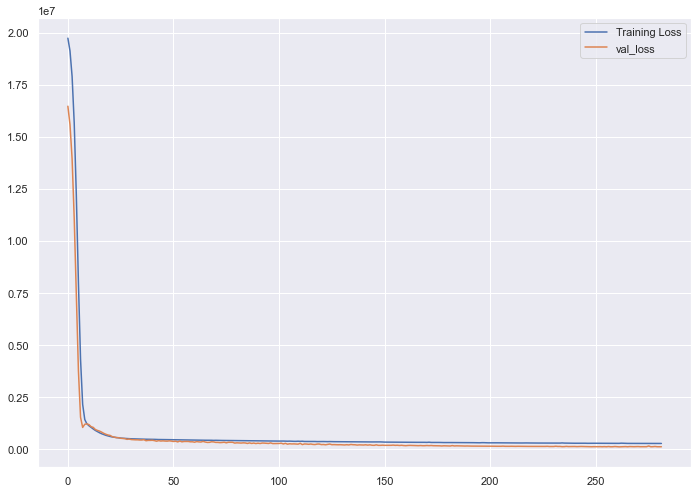

In [12]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history['val_loss'], label="val_loss")
plt.legend()
plt.show()

In [13]:
x_test.shape

(65, 6)

<function matplotlib.pyplot.show(close=None, block=None)>

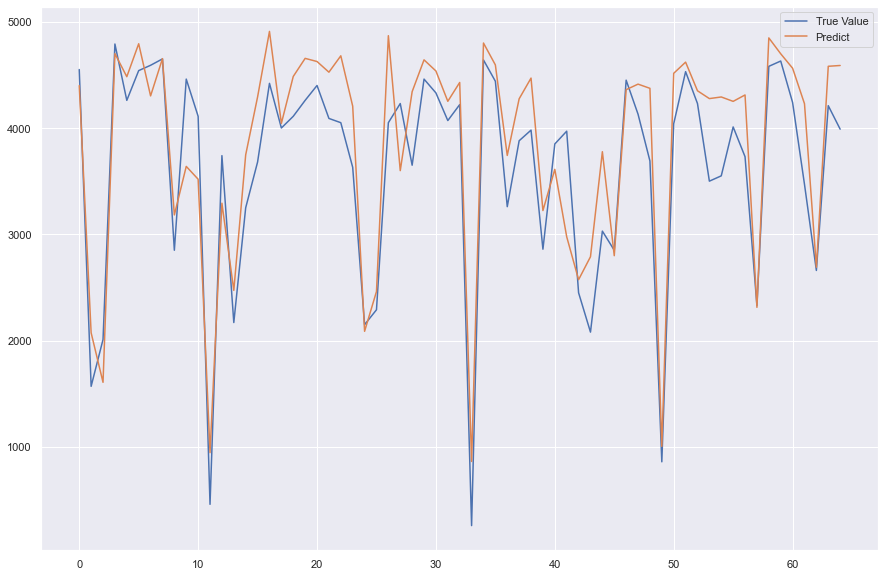

In [17]:
x_pred = x_test.reshape((x_test.shape[0], n_seq, n_steps, n_features))
y_pred = model.predict(x_pred)
plt.figure(figsize=(15,10))
plt.plot(y_test, label="True Value")
plt.plot(y_pred, label="Predict")
plt.legend()
plt.show

In [15]:
model.save("ens_predict_CNNLSTM.h5")
